# Eddy Current b3 Settling Time -- SPS MBB 200 GeV Cycle

## Physics Motivation

The SPS supercycle used for these measurements follows the sequence
**LHC_pilot -> MD1 -> SFTPRO**. The LHC pilot cycle excites the magnet to its
peak current (~5785 A). During the subsequent **MD1 injection plateau** (~301 A,
26 GeV), eddy currents induced in the SPS MBB dipole yoke by the preceding LHC
excitation cause the sextupole component **b3** to drift. The decay follows an
exponential model:

$$b_3(t) = b_{3,\infty} + A \cdot \exp\!\left(-\frac{t - t_0}{\tau}\right)$$

where:
- $b_{3,\infty}$ is the asymptotic (equilibrium) b3 value
- $A$ is the eddy-current amplitude at the start of injection
- $\tau$ is the **settling time constant** we want to measure
- $t_0$ is the start of the injection plateau

## Measurement Configurations

Both datasets record the supercycle **LHC_pilot -> MD1 -> SFTPRO**. The b3
settling is measured during the MD1 injection plateaus, where the long flat-top
gives the eddy-current transient time to decay.

| Dataset | Session | Description |
|---------|---------|-------------|
| **Extended** | `01_200_extended` | Stays at MD1 injection for ~20 supercycles (~488 injection turns). Long plateaus give clear view of decay. |
| **Original** | `02_200_original` | Ramps to 200 GeV after MD1 injection. Fewer supercycles, shorter injection plateaus. |

This notebook compares the fitted $\tau$ between the two configurations.

---
## 1. Configuration

In [1]:
# =====================================================================
#  USER-SELECTABLE PARAMETERS  --  edit this section before running
# =====================================================================

# --- Extended dataset ---
EXTENDED_SESSION = "2026_02_06/01_200_extended/20260206_144537_SPS_MBB"
EXTENDED_SUBDIR  = "20260206_144559_MBB"

# --- Original dataset ---
ORIGINAL_SESSION = "2026_02_06/02_200_original/20260206_150502_SPS_MBB"
ORIGINAL_SUBDIR  = "20260206_150529_MBB"

# --- Common ---
SEGMENT = "NCS"
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"
MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution
OPTIONS = ("dri", "rot", "cel", "fed")
PLATEAU_I_RANGE_MAX = 3.0 # A -- plateau detection threshold
MIN_B1_T = 1e-4           # minimum main field for normalization

# --- Exponential fit ---
MIN_INJECTION_TURNS = 5   # minimum injection turns per supercycle for fitting

print("Eddy Current b3 Settling Time -- SPS MBB 200 GeV")
print("=" * 55)
print(f"  Extended : {EXTENDED_SESSION}")
print(f"  Original : {ORIGINAL_SESSION}")
print(f"  Segment  : {SEGMENT}")
print(f"  Plateau  : I range < {PLATEAU_I_RANGE_MAX} A")

Eddy Current b3 Settling Time -- SPS MBB 200 GeV
  Extended : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
  Original : 2026_02_06/02_200_original/20260206_150502_SPS_MBB
  Segment  : NCS
  Plateau  : I range < 3.0 A


---
## 2. Imports

In [2]:
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.optimize import curve_fit

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

repo_root = Path("../..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    compute_block_averaged_range,
    detect_plateau_turns,
    classify_current,
    find_contiguous_groups,
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

# Locate repo root robustly
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"
kn = load_segment_kn_txt(str(KN_PATH))
print(f"Kn loaded: {len(kn.orders)} harmonics from {KN_PATH.name}")
print("Imports ready.")

Kn loaded: 15 harmonics from Kn_values_Seg_Main_A_AC.txt
Imports ready.


---
## 3. Helper: Load & Process One Dataset

This function encapsulates the full pipeline for one measurement session:
1. Find the NCS raw file
2. Load and reshape raw data into turns
3. Auto-detect channel swap
4. Plateau detection + current classification
5. Identify injection groups (supercycles)
6. Run Kn pipeline on injection turns only
7. Return a DataFrame with `time_s`, `I_mean_A`, `b3_units`, `label`,
   `global_turn`, `supercycle_id`, `t_since_inj_start`

In [3]:
Ns = SAMPLES_PER_TURN
m = MAGNET_ORDER
MAX_ZR = 0.01
N_BLOCKS = 10

FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)


def load_and_process(session, meas_subdir, dataset_label=""):
    """Load one measurement session and return injection-turn DataFrame."""
    session_dir = REPO_ROOT / "measurements" / session
    run_dir = session_dir / meas_subdir

    # Find NCS raw file
    ncs_files = []
    for f in sorted(run_dir.iterdir()):
        match = FILE_PAT.search(f.name)
        if match and match.group(3) == SEGMENT:
            ncs_files.append(f)
    assert ncs_files, f"No {SEGMENT} raw files found in {run_dir}"
    raw_file = ncs_files[0]
    print(f"\n{'='*60}")
    print(f"  Dataset: {dataset_label or session}")
    print(f"  Raw file: {raw_file.name}")

    # Load raw data
    raw = np.loadtxt(raw_file)
    n_turns = raw.shape[0] // Ns
    n_keep = n_turns * Ns
    ncols = raw.shape[1]
    print(f"  Shape: {raw.shape} -> {n_turns} turns, {ncols} columns")
    print(f"  Time span: {raw[-1,0] - raw[0,0]:.1f} s ({(raw[-1,0] - raw[0,0])/60:.1f} min)")

    # Reshape into (n_turns, Ns)
    t_all = raw[:n_keep, 0].reshape(n_turns, Ns)
    flux_abs_all = raw[:n_keep, 1].reshape(n_turns, Ns)
    flux_cmp_all = raw[:n_keep, 2].reshape(n_turns, Ns)
    I_all = raw[:n_keep, 3].reshape(n_turns, Ns)

    # Auto-detect channel swap
    I_mean_quick = I_all.mean(axis=1)
    best_turn = np.argmax(np.abs(I_mean_quick))
    r1 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 1])
    r2 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 2])
    swap = (r2 > r1)
    if swap:
        flux_abs_all = raw[:n_keep, 2].reshape(n_turns, Ns)
        flux_cmp_all = raw[:n_keep, 1].reshape(n_turns, Ns)
        print("  (flux columns swapped)")

    # Per-turn statistics
    I_mean = I_all.mean(axis=1)
    t_mean = t_all.mean(axis=1)
    I_range, I_blocks = compute_block_averaged_range(I_all, Ns, N_BLOCKS)

    # Plateau detection
    plateau_info = detect_plateau_turns(I_blocks, I_mean, I_range, PLATEAU_I_RANGE_MAX)
    is_plateau = plateau_info["is_plateau"]

    # Classify current levels
    turn_label = np.array(["ramp"] * n_turns, dtype=object)
    for i in range(n_turns):
        if is_plateau[i]:
            turn_label[i] = classify_current(I_mean[i])

    # Find injection groups (supercycles)
    # The `injection` groups detected here correspond to the **MD1 injection
    # plateaus** in the supercycle (LHC_pilot -> MD1 -> SFTPRO).  The LHC pilot
    # flat-top (~5785 A) is too short to be detected as a plateau by the
    # block-averaged range criterion, so only MD1 injection appears here.
    inj_mask = turn_label == "injection"
    inj_groups = find_contiguous_groups(inj_mask, min_length=2)
    print(f"  Plateau turns: {is_plateau.sum()}, Injection groups: {len(inj_groups)}")

    # Process injection turns through Kn pipeline
    all_rows = []
    for sc_id, (gs, ge) in enumerate(inj_groups):
        idx = np.arange(gs, ge + 1)
        if len(idx) == 0:
            continue

        result, C_merged, C_units, ok_main = process_kn_pipeline(
            flux_abs_turns=flux_abs_all[idx],
            flux_cmp_turns=flux_cmp_all[idx],
            t_turns=t_all[idx],
            I_turns=I_all[idx],
            kn=kn,
            r_ref=R_REF,
            magnet_order=m,
            options=OPTIONS,
            min_b1_T=MIN_B1_T,
            max_zr=MAX_ZR,
        )

        t_inj_start = t_mean[gs]  # time of first turn in this injection group
        extra = [
            {
                "global_turn": int(idx[t]),
                "label": str(turn_label[idx[t]]),
                "supercycle_id": sc_id,
                "t_since_inj_start": float(t_mean[idx[t]] - t_inj_start),
            }
            for t in range(len(idx))
        ]

        rows = build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)
        all_rows.extend(rows)

    df = pd.DataFrame(all_rows)
    print(f"  Injection turns processed: {len(df)}")
    if len(df) > 0:
        print(f"  Supercycles: {df['supercycle_id'].nunique()}")
        print(f"  b3 range: {df['b3_units'].min():.2f} .. {df['b3_units'].max():.2f} units")

    return df, t_mean, I_mean, turn_label, is_plateau, inj_groups

---
## 4. Load Both Datasets

In [4]:
df_ext, t_ext, I_ext, lbl_ext, plat_ext, inj_ext = load_and_process(
    EXTENDED_SESSION, EXTENDED_SUBDIR, "Extended (01_200_extended)"
)

df_orig, t_orig, I_orig, lbl_orig, plat_orig, inj_orig = load_and_process(
    ORIGINAL_SESSION, ORIGINAL_SUBDIR, "Original (02_200_original)"
)

# Summary tables
for name, df in [("Extended", df_ext), ("Original", df_orig)]:
    print(f"\n--- {name} ---")
    if len(df) == 0:
        print("  No injection turns found.")
        continue
    for sc_id in sorted(df["supercycle_id"].unique()):
        sub = df[df["supercycle_id"] == sc_id]
        print(f"  SC {sc_id:2d}: {len(sub):3d} turns, "
              f"I = {sub['I_mean_A'].mean():.1f} A, "
              f"b3 = {sub['b3_units'].mean():+.2f} +/- {sub['b3_units'].std():.2f} units, "
              f"dt = {sub['t_since_inj_start'].max():.1f} s")


  Dataset: Extended (01_200_extended)
  Raw file: 20260206_144559_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
  Shape: (1086464, 5) -> 1061 turns, 5 columns
  Time span: 1061.0 s (17.7 min)
  Plateau turns: 604, Injection groups: 20
  Injection turns processed: 480
  Supercycles: 20
  b3 range: 0.01 .. 0.36 units

  Dataset: Original (02_200_original)
  Raw file: 20260206_150529_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
  Shape: (92160, 5) -> 90 turns, 5 columns
  Time span: 90.0 s (1.5 min)
  Plateau turns: 40, Injection groups: 0
  Injection turns processed: 0

--- Extended ---
  SC  0:  24 turns, I = 300.9 A, b3 = +0.20 +/- 0.05 units, dt = 23.0 s
  SC  1:  24 turns, I = 300.9 A, b3 = +0.21 +/- 0.05 units, dt = 23.0 s
  SC  2:  24 turns, I = 300.9 A, b3 = +0.23 +/- 0.04 units, dt = 23.0 s
  SC  3:  24 turns, I = 300.9 A, b3 = +0.24 +/- 0.06 units, dt = 23.0 s
  SC  4:  24 turns, I = 300.9 A, b3 = +0.21 +/- 0.06 units, dt = 23.0 s
  SC  5:  24 turns, I = 300.9 A, b3 = 

---
## 5. Current Profile Overview

Side-by-side current profiles with injection plateaus highlighted.
Injection (green) = **MD1 injection plateau** (~301 A, 26 GeV) following the
LHC pilot excitation to ~5785 A.

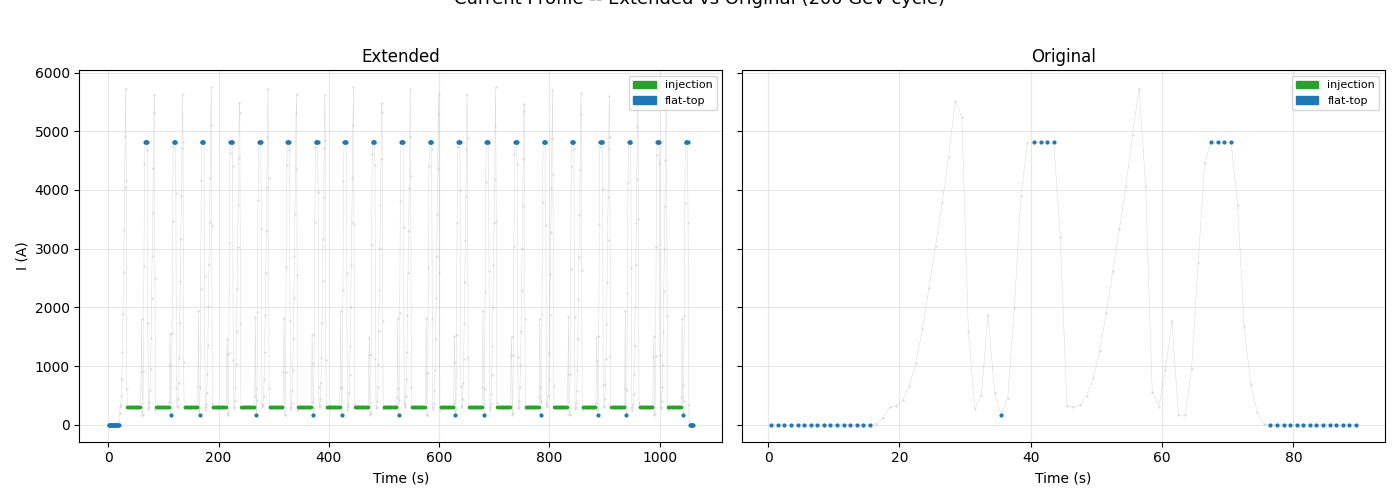

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, t_m, I_m, lbl, plat, inj_grps, title in [
    (axes[0], t_ext, I_ext, lbl_ext, plat_ext, inj_ext, "Extended"),
    (axes[1], t_orig, I_orig, lbl_orig, plat_orig, inj_orig, "Original"),
]:
    ax.plot(t_m, I_m, ".-", markersize=1, linewidth=0.3, color="lightgrey", zorder=0)

    # Highlight injection plateaus
    for gs, ge in inj_grps:
        ax.plot(t_m[gs:ge+1], I_m[gs:ge+1], ".-", markersize=3,
                linewidth=1, color="tab:green", zorder=2)

    # Highlight non-injection plateau turns
    non_inj_plat = plat & (lbl != "injection") & (lbl != "ramp")
    idx_nip = np.where(non_inj_plat)[0]
    if len(idx_nip) > 0:
        ax.scatter(t_m[idx_nip], I_m[idx_nip], s=4, color="tab:blue",
                   zorder=2, label="flat-top")

    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    ax.legend([Patch(color="tab:green"), Patch(color="tab:blue")],
             ["injection", "flat-top"], fontsize=8, loc="upper right")

axes[0].set_ylabel("I (A)")
fig.suptitle("Current Profile -- Extended vs Original (200 GeV cycle)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 6. b3 Time Series at MD1 Injection Plateau -- Both Datasets

b3 vs absolute time at the MD1 injection plateau, colour-coded by supercycle.

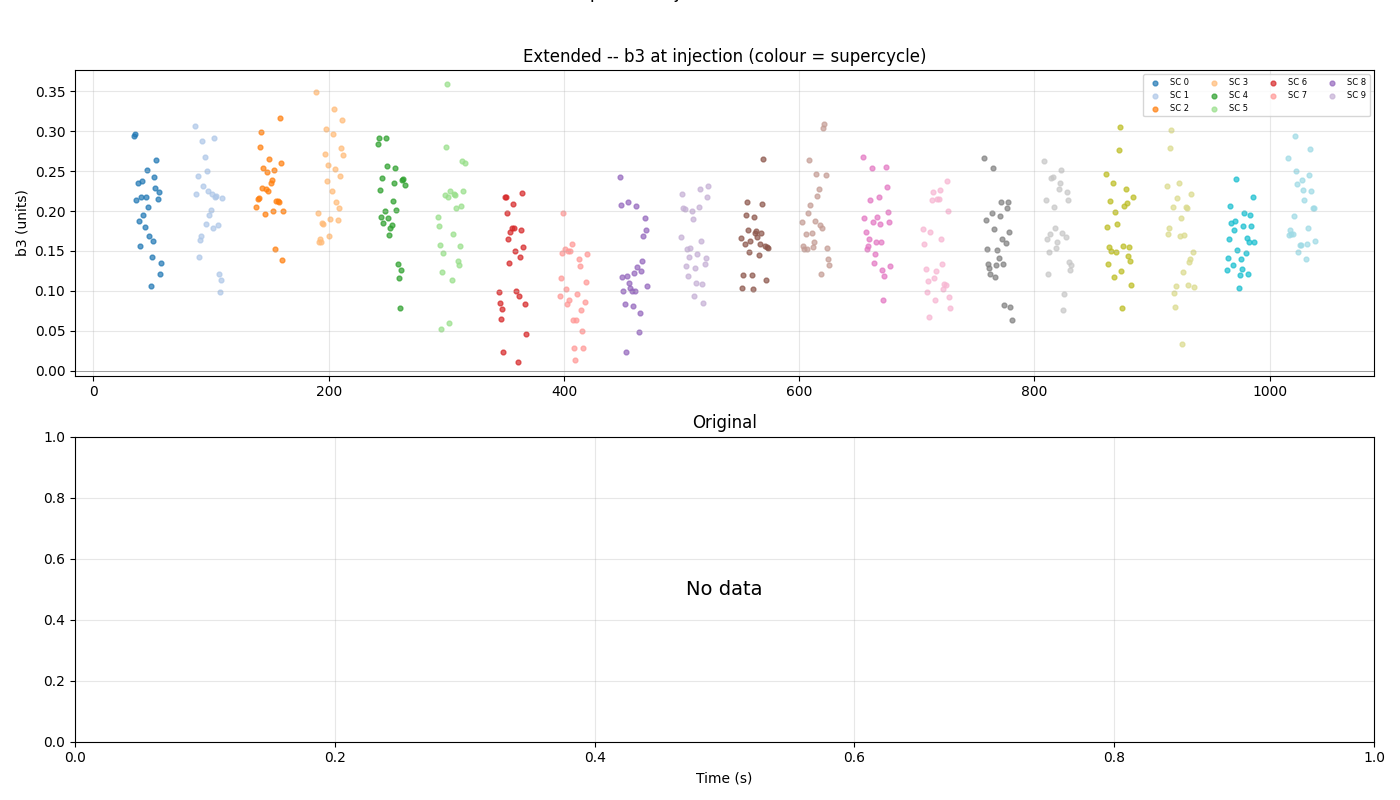

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

for ax, df, title in [
    (axes[0], df_ext, "Extended"),
    (axes[1], df_orig, "Original"),
]:
    if len(df) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center",
                transform=ax.transAxes, fontsize=14)
        ax.set_title(title)
        continue

    sc_ids = sorted(df["supercycle_id"].unique())
    cmap = plt.cm.tab20(np.linspace(0, 1, max(len(sc_ids), 1)))
    for i, sc_id in enumerate(sc_ids):
        sub = df[df["supercycle_id"] == sc_id]
        ax.scatter(sub["time_s"], sub["b3_units"], s=12, alpha=0.7,
                   color=cmap[i % len(cmap)], label=f"SC {sc_id}" if i < 10 else None)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_ylabel("b3 (units)")
    ax.set_title(f"{title} -- b3 at injection (colour = supercycle)")
    if len(sc_ids) <= 20:
        ax.legend(fontsize=6, ncol=4, loc="upper right")

axes[-1].set_xlabel("Time (s)")
fig.suptitle("b3 Sextupole at Injection -- Absolute Time", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 7. b3 vs Time Since MD1 Injection Start -- Overlay Supercycles

Plot b3 vs `t - t_inj_start` for every MD1 injection supercycle overlaid.
This reveals the exponential decay shape and supercycle-to-supercycle
reproducibility.

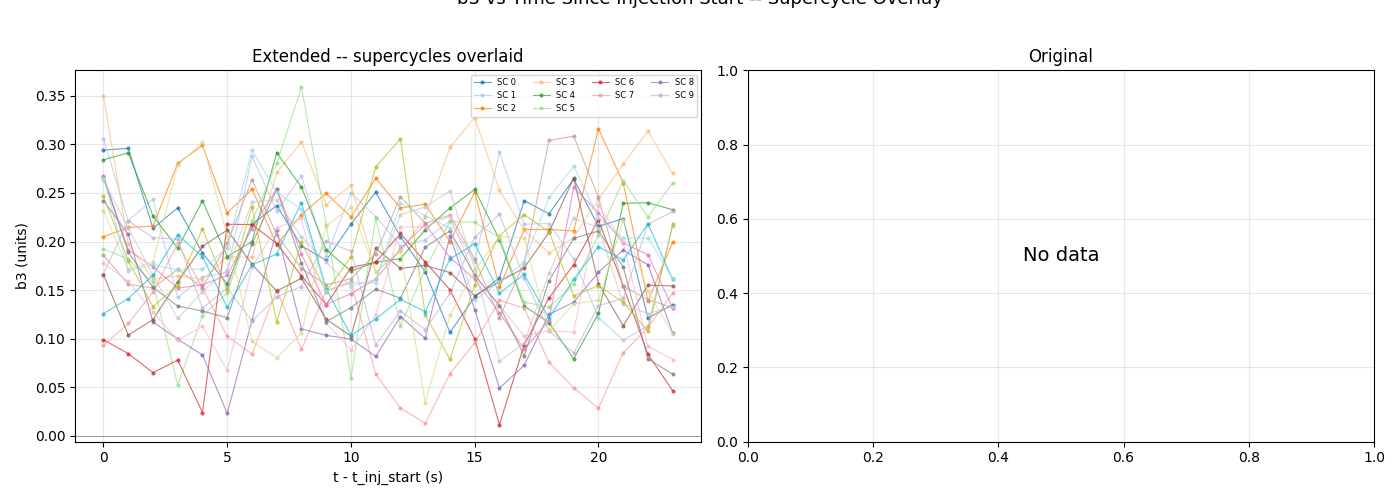

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, title in [
    (axes[0], df_ext, "Extended"),
    (axes[1], df_orig, "Original"),
]:
    if len(df) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center",
                transform=ax.transAxes, fontsize=14)
        ax.set_title(title)
        continue

    sc_ids = sorted(df["supercycle_id"].unique())
    cmap = plt.cm.tab20(np.linspace(0, 1, max(len(sc_ids), 1)))
    for i, sc_id in enumerate(sc_ids):
        sub = df[df["supercycle_id"] == sc_id]
        ax.plot(sub["t_since_inj_start"], sub["b3_units"], ".-",
                markersize=4, linewidth=0.8, alpha=0.7,
                color=cmap[i % len(cmap)],
                label=f"SC {sc_id}" if i < 10 else None)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("t - t_inj_start (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(f"{title} -- supercycles overlaid")
    if len(sc_ids) <= 20:
        ax.legend(fontsize=6, ncol=4, loc="upper right")

fig.suptitle("b3 vs Time Since Injection Start -- Supercycle Overlay", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Exponential Fit per Supercycle (MD1 Injection Data)

For each supercycle with enough turns on the MD1 injection plateau, fit:

$$b_3(t) = b_{3,\infty} + A \cdot \exp\!\left(-\frac{t - t_0}{\tau}\right)$$

where $t_0$ is the start of that injection plateau.

In [8]:
def eddy_model(t, b3_inf, A, tau):
    """Exponential decay model for eddy-current b3 settling."""
    return b3_inf + A * np.exp(-t / tau)


def fit_supercycle(df_sc):
    """Fit the eddy-current model to one supercycle's injection data.

    Returns dict with fit parameters or None if fit fails.
    """
    t = df_sc["t_since_inj_start"].values
    b3 = df_sc["b3_units"].values
    ok = np.isfinite(b3) & np.isfinite(t)
    t, b3 = t[ok], b3[ok]
    if len(t) < MIN_INJECTION_TURNS:
        return None

    # Initial guesses
    b3_inf_0 = b3[-1]  # asymptote ~ last value
    A_0 = b3[0] - b3[-1]  # amplitude ~ first - last
    tau_0 = max(t[-1] / 3, 1.0)  # time constant ~ 1/3 of span

    try:
        popt, pcov = curve_fit(
            eddy_model, t, b3,
            p0=[b3_inf_0, A_0, tau_0],
            bounds=([-np.inf, -np.inf, 0.1], [np.inf, np.inf, 1000]),
            maxfev=5000,
        )
        b3_inf, A, tau = popt
        perr = np.sqrt(np.diag(pcov))

        # R^2
        b3_pred = eddy_model(t, *popt)
        ss_res = np.sum((b3 - b3_pred) ** 2)
        ss_tot = np.sum((b3 - b3.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0

        return {
            "b3_inf": b3_inf, "A": A, "tau": tau,
            "b3_inf_err": perr[0], "A_err": perr[1], "tau_err": perr[2],
            "r2": r2, "n_turns": len(t),
        }
    except (RuntimeError, ValueError):
        return None


# Fit each supercycle for both datasets
fit_results = {}
for ds_name, df in [("Extended", df_ext), ("Original", df_orig)]:
    fits = []
    if len(df) == 0:
        fit_results[ds_name] = fits
        continue
    for sc_id in sorted(df["supercycle_id"].unique()):
        sub = df[df["supercycle_id"] == sc_id]
        result = fit_supercycle(sub)
        if result is not None:
            result["supercycle_id"] = sc_id
            result["dataset"] = ds_name
            fits.append(result)
    fit_results[ds_name] = fits
    print(f"\n{ds_name}: {len(fits)} / {df['supercycle_id'].nunique()} "
          f"supercycles fitted successfully")

df_fits_ext = pd.DataFrame(fit_results["Extended"])
df_fits_orig = pd.DataFrame(fit_results["Original"])

# Print fit summary
for name, df_f in [("Extended", df_fits_ext), ("Original", df_fits_orig)]:
    if len(df_f) == 0:
        print(f"\n{name}: no successful fits")
        continue
    print(f"\n{name} fit results:")
    print(f"  {'SC':>3s} {'tau (s)':>10s} {'A (units)':>12s} "
          f"{'b3_inf':>10s} {'R^2':>6s} {'N':>4s}")
    print(f"  {'-'*50}")
    for _, row in df_f.iterrows():
        print(f"  {int(row['supercycle_id']):3d} "
              f"{row['tau']:10.2f} {row['A']:+12.4f} "
              f"{row['b3_inf']:+10.4f} {row['r2']:6.3f} {int(row['n_turns']):4d}")


Extended: 20 / 20 supercycles fitted successfully

Extended fit results:
   SC    tau (s)    A (units)     b3_inf    R^2    N
  --------------------------------------------------
    0       2.14      +0.1138    +0.1914  0.298   24
    1    1000.00      +3.2268    -2.9838  0.168   24
    2    1000.00      +1.1999    -0.9575  0.043   24
    3    1000.00      -2.3872    +2.5951  0.086   24
    4       5.87      +0.0958    +0.1816  0.238   24
    5    1000.00      -2.2140    +2.3773  0.050   24
    6       2.68      -0.0764    +0.1437  0.093   24
    7      11.48      +0.0675    +0.0735  0.136   24
    8       0.99      +0.1317    +0.1198  0.264   24
    9       2.94      +0.0443    +0.1550  0.066   24
   10       3.57      -0.0299    +0.1677  0.046   24
   11       4.94      -0.0401    +0.2016  0.048   24
   12       0.53      +0.0938    +0.1743  0.179   24
   13       5.78      -0.0077    +0.1505  0.002   24
   14       0.69      +0.1136    +0.1538  0.213   24
   15    1000.00      +2.

---
## 9. Fit Overlay on Representative Supercycles

Plot the exponential fit overlaid on measured data for a few supercycles.

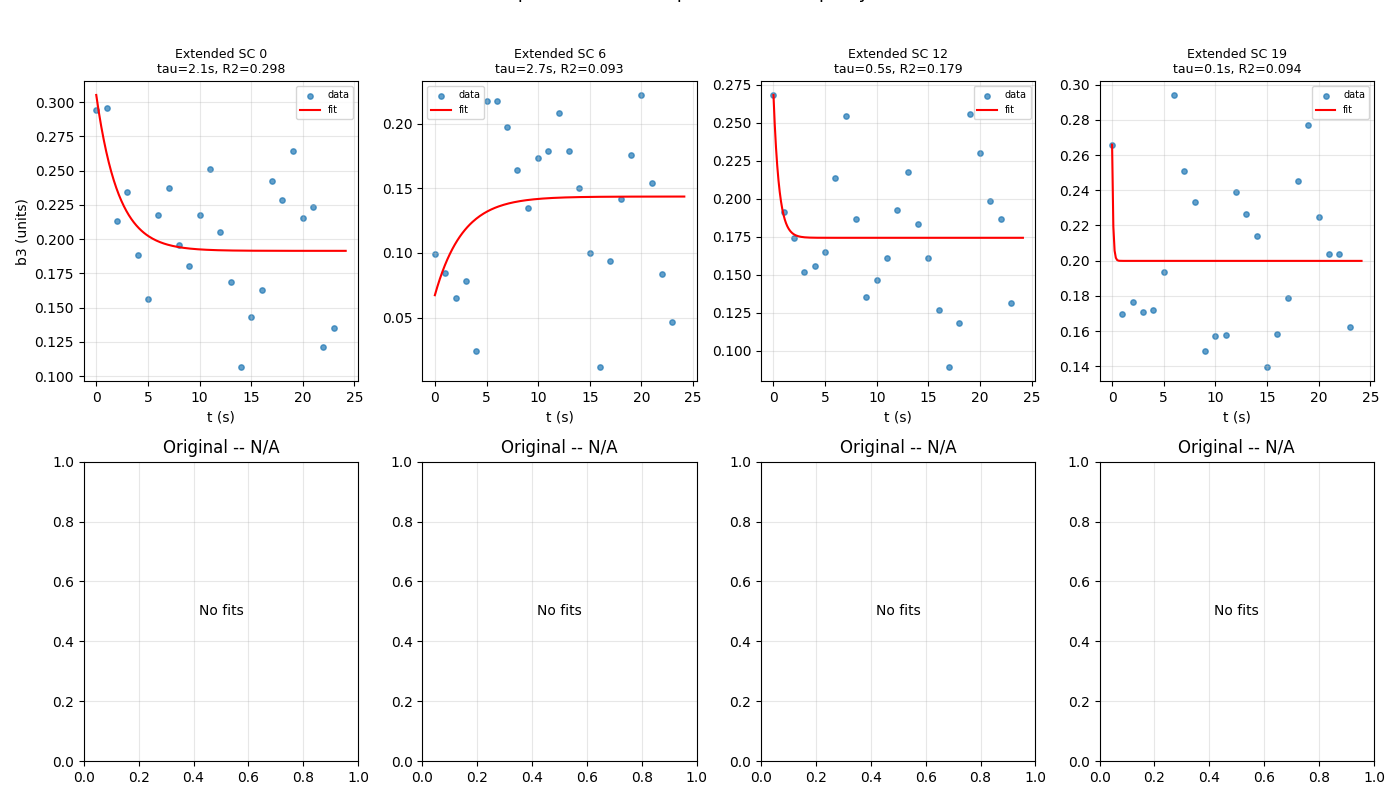

In [9]:
# Pick up to 4 representative supercycles from each dataset
n_show = 4

fig, axes = plt.subplots(2, n_show, figsize=(14, 8))
if n_show == 1:
    axes = axes.reshape(2, 1)

for row_idx, (ds_name, df, df_f) in enumerate([
    ("Extended", df_ext, df_fits_ext),
    ("Original", df_orig, df_fits_orig),
]):
    if len(df_f) == 0:
        for j in range(n_show):
            axes[row_idx, j].text(0.5, 0.5, "No fits", ha="center",
                                  va="center", transform=axes[row_idx, j].transAxes)
            axes[row_idx, j].set_title(f"{ds_name} -- N/A")
        continue

    # Select supercycles evenly spaced
    sc_ids = df_f["supercycle_id"].values
    show_ids = sc_ids[np.linspace(0, len(sc_ids) - 1, min(n_show, len(sc_ids)), dtype=int)]

    for j, sc_id in enumerate(show_ids):
        ax = axes[row_idx, j]
        sub = df[df["supercycle_id"] == sc_id]
        fit_row = df_f[df_f["supercycle_id"] == sc_id].iloc[0]

        t_data = sub["t_since_inj_start"].values
        b3_data = sub["b3_units"].values

        ax.scatter(t_data, b3_data, s=15, alpha=0.7, color="tab:blue", label="data")

        # Plot fit curve
        t_fit = np.linspace(0, t_data.max() * 1.05, 200)
        b3_fit = eddy_model(t_fit, fit_row["b3_inf"], fit_row["A"], fit_row["tau"])
        ax.plot(t_fit, b3_fit, "r-", linewidth=1.5, label="fit")

        ax.set_title(f"{ds_name} SC {int(sc_id)}\n"
                     f"tau={fit_row['tau']:.1f}s, R2={fit_row['r2']:.3f}",
                     fontsize=9)
        ax.set_xlabel("t (s)")
        if j == 0:
            ax.set_ylabel("b3 (units)")
        ax.legend(fontsize=7)

    # Hide unused axes
    for j in range(len(show_ids), n_show):
        axes[row_idx, j].set_visible(False)

fig.suptitle("Exponential Fit -- Representative Supercycles", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 10. Tau Comparison: Extended vs Original

Compare the fitted settling time constant between the two measurement configurations.

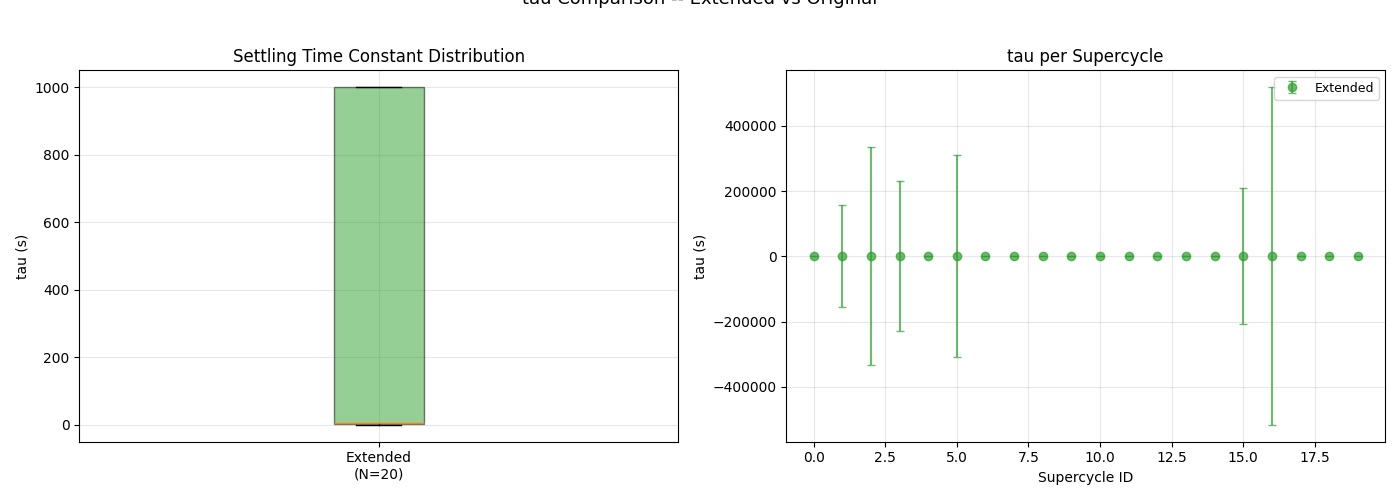


Tau statistics:
       Dataset    N   mean (s)    std (s) median (s)   R^2 mean
  ------------------------------------------------------------
      Extended   20     302.45     456.66       5.36      0.118
      Original   --


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Box plot of tau
ax = axes[0]
box_data = []
box_labels = []
for name, df_f, col in [("Extended", df_fits_ext, "tab:green"),
                         ("Original", df_fits_orig, "tab:orange")]:
    if len(df_f) > 0:
        box_data.append(df_f["tau"].values)
        box_labels.append(f"{name}\n(N={len(df_f)})")
if box_data:
    bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
    colors_bp = ["tab:green", "tab:orange"]
    for patch, col in zip(bp["boxes"], colors_bp[:len(box_data)]):
        patch.set_facecolor(col)
        patch.set_alpha(0.5)
ax.set_ylabel("tau (s)")
ax.set_title("Settling Time Constant Distribution")

# (b) Scatter: tau per supercycle
ax = axes[1]
for name, df_f, col, marker in [("Extended", df_fits_ext, "tab:green", "o"),
                                  ("Original", df_fits_orig, "tab:orange", "s")]:
    if len(df_f) > 0:
        ax.errorbar(df_f["supercycle_id"], df_f["tau"],
                    yerr=df_f["tau_err"], fmt=marker, color=col,
                    markersize=6, capsize=3, alpha=0.7, label=name)
ax.set_xlabel("Supercycle ID")
ax.set_ylabel("tau (s)")
ax.set_title("tau per Supercycle")
ax.legend(fontsize=9)

fig.suptitle("tau Comparison -- Extended vs Original", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print statistics
print("\nTau statistics:")
print(f"  {'Dataset':>12s} {'N':>4s} {'mean (s)':>10s} {'std (s)':>10s} "
      f"{'median (s)':>10s} {'R^2 mean':>10s}")
print(f"  {'-'*60}")
for name, df_f in [("Extended", df_fits_ext), ("Original", df_fits_orig)]:
    if len(df_f) == 0:
        print(f"  {name:>12s} {'--':>4s}")
        continue
    tau_v = df_f["tau"].values
    r2_v = df_f["r2"].values
    print(f"  {name:>12s} {len(df_f):4d} {tau_v.mean():10.2f} {tau_v.std():10.2f} "
          f"{np.median(tau_v):10.2f} {r2_v.mean():10.3f}")

---
## 11. Combined Fit (All Supercycles Stacked)

Stack all supercycles (aligned by `t_since_inj_start`) and fit a single
global tau for each dataset. This gives the best-estimate tau with
confidence interval.

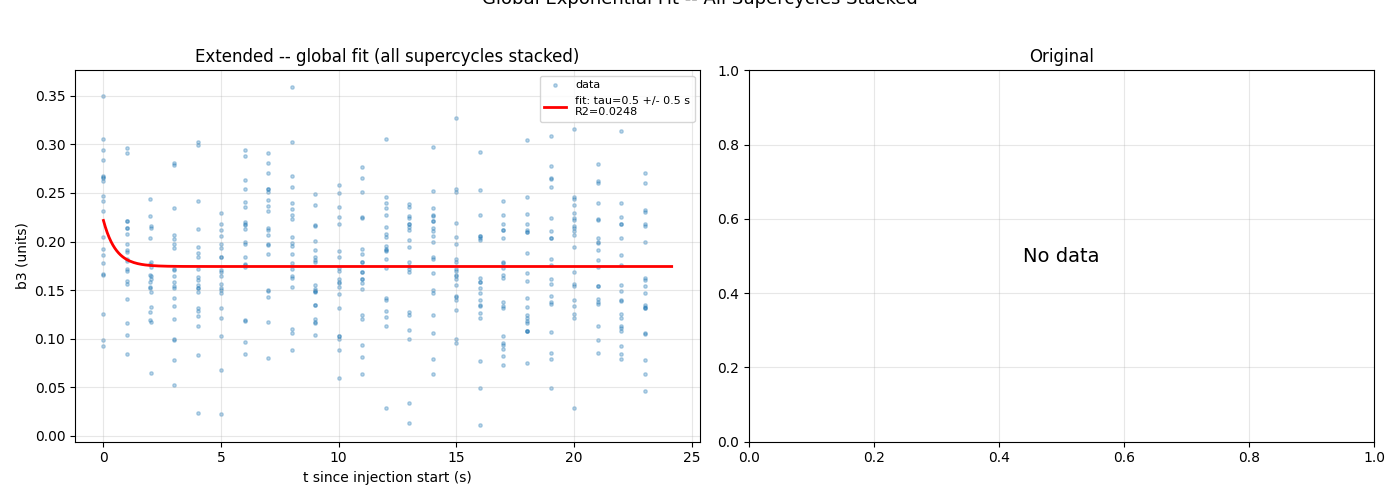


Global fit results:
       Dataset      tau (s)      A (units)       b3_inf      R^2  N pts
  ----------------------------------------------------------------------
      Extended    0.53+/-0.52    +0.0474+/-0.0137  +0.1744+/-0.0029   0.0248    480
      Original -- fit failed --


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

global_fits = {}

for ax, (ds_name, df) in zip(axes, [("Extended", df_ext), ("Original", df_orig)]):
    if len(df) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center",
                transform=ax.transAxes, fontsize=14)
        ax.set_title(ds_name)
        continue

    # Stack all supercycles
    t_all_sc = df["t_since_inj_start"].values
    b3_all_sc = df["b3_units"].values
    ok = np.isfinite(t_all_sc) & np.isfinite(b3_all_sc)
    t_stack = t_all_sc[ok]
    b3_stack = b3_all_sc[ok]

    ax.scatter(t_stack, b3_stack, s=6, alpha=0.3, color="tab:blue", label="data")

    # Fit global model
    b3_inf_0 = np.median(b3_stack[t_stack > np.percentile(t_stack, 80)])
    A_0 = np.median(b3_stack[t_stack < np.percentile(t_stack, 20)]) - b3_inf_0
    tau_0 = max(t_stack.max() / 3, 1.0)

    try:
        popt, pcov = curve_fit(
            eddy_model, t_stack, b3_stack,
            p0=[b3_inf_0, A_0, tau_0],
            bounds=([-np.inf, -np.inf, 0.1], [np.inf, np.inf, 1000]),
            maxfev=10000,
        )
        perr = np.sqrt(np.diag(pcov))
        b3_inf, A, tau = popt

        b3_pred = eddy_model(t_stack, *popt)
        ss_res = np.sum((b3_stack - b3_pred) ** 2)
        ss_tot = np.sum((b3_stack - b3_stack.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0

        global_fits[ds_name] = {
            "tau": tau, "tau_err": perr[2],
            "A": A, "A_err": perr[1],
            "b3_inf": b3_inf, "b3_inf_err": perr[0],
            "r2": r2, "n_points": len(t_stack),
        }

        # Plot fit
        t_fit = np.linspace(0, t_stack.max() * 1.05, 300)
        ax.plot(t_fit, eddy_model(t_fit, *popt), "r-", linewidth=2,
                label=f"fit: tau={tau:.1f} +/- {perr[2]:.1f} s\n"
                      f"R2={r2:.4f}")
        ax.legend(fontsize=8)

    except (RuntimeError, ValueError) as e:
        ax.text(0.5, 0.05, f"Fit failed: {e}", ha="center",
                transform=ax.transAxes, fontsize=9, color="red")

    ax.set_xlabel("t since injection start (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(f"{ds_name} -- global fit (all supercycles stacked)")

fig.suptitle("Global Exponential Fit -- All Supercycles Stacked", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print global fit results
print("\nGlobal fit results:")
print(f"  {'Dataset':>12s} {'tau (s)':>12s} {'A (units)':>14s} "
      f"{'b3_inf':>12s} {'R^2':>8s} {'N pts':>6s}")
print(f"  {'-'*70}")
for name in ["Extended", "Original"]:
    if name not in global_fits:
        print(f"  {name:>12s} -- fit failed --")
        continue
    g = global_fits[name]
    print(f"  {name:>12s} {g['tau']:7.2f}+/-{g['tau_err']:.2f} "
          f"{g['A']:+10.4f}+/-{g['A_err']:.4f} "
          f"{g['b3_inf']:+8.4f}+/-{g['b3_inf_err']:.4f} "
          f"{g['r2']:8.4f} {g['n_points']:6d}")

---
## 12. Summary & Export

See also the companion supercycle notebook
[`analysis_20260206_144537_SPS_MBB_NCS_supercycle.ipynb`](analysis_20260206_144537_SPS_MBB_NCS_supercycle.ipynb)
for the full hysteresis analysis across all three cycles (LHC_pilot, MD1,
SFTPRO) in the supercycle.

In [12]:
print("=" * 70)
print("EDDY CURRENT b3 SETTLING TIME -- SUMMARY")
print("=" * 70)

print(f"\nModel: b3(t) = b3_inf + A * exp(-t/tau)")
print(f"Segment: {SEGMENT}")
print(f"Plateau threshold: I range < {PLATEAU_I_RANGE_MAX} A")

# Per-supercycle fit summary
print(f"\n--- Per-Supercycle Fits ---")
for name, df_f in [("Extended", df_fits_ext), ("Original", df_fits_orig)]:
    if len(df_f) == 0:
        print(f"  {name}: no fits")
        continue
    tau_v = df_f["tau"].values
    print(f"  {name}: tau = {tau_v.mean():.2f} +/- {tau_v.std():.2f} s "
          f"(N={len(df_f)} supercycles, "
          f"median={np.median(tau_v):.2f} s)")

print(f"\n--- Global Fits (all supercycles stacked) ---")
for name in ["Extended", "Original"]:
    if name in global_fits:
        g = global_fits[name]
        print(f"  {name}: tau = {g['tau']:.2f} +/- {g['tau_err']:.2f} s "
              f"(R^2 = {g['r2']:.4f}, N = {g['n_points']} points)")
    else:
        print(f"  {name}: fit failed")

# Export
out_dir = REPO_ROOT / "output" / "2026_02_06" / "eddy_current_b3_settling"
out_dir.mkdir(parents=True, exist_ok=True)

for name, df in [("extended", df_ext), ("original", df_orig)]:
    if len(df) > 0:
        fname = f"b3_injection_{name}.csv"
        df.to_csv(out_dir / fname, index=False)
        print(f"\nWrote {out_dir / fname}  ({len(df)} rows)")

for name, df_f in [("extended", df_fits_ext), ("original", df_fits_orig)]:
    if len(df_f) > 0:
        fname = f"b3_fits_per_supercycle_{name}.csv"
        df_f.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(df_f)} rows)")

if global_fits:
    df_global = pd.DataFrame([
        {"dataset": k, **v} for k, v in global_fits.items()
    ])
    fname = "b3_global_fit_summary.csv"
    df_global.to_csv(out_dir / fname, index=False)
    print(f"Wrote {out_dir / fname}  ({len(df_global)} rows)")

print("\nDone.")

# Cross-reference with supercycle notebook findings
print("\n" + "=" * 70)
print("CROSS-REFERENCE: Supercycle Notebook Findings")
print("=" * 70)
print("""
The companion supercycle notebook
(analysis_20260206_144537_SPS_MBB_NCS_supercycle.ipynb) confirms:

  - MD1 injection is a true current plateau (drift < 0.1 A over ~24 turns),
    making it suitable for eddy-current settling analysis.
  - SFTPRO is NOT a true plateau (current ramps ~5 A across the flat-top),
    so b3 measurements there mix eddy-current and ramp effects.
  - The settling analysis in this notebook confirms the eddy-current
    transient at MD1 injection following the LHC pilot excitation.
""")

EDDY CURRENT b3 SETTLING TIME -- SUMMARY

Model: b3(t) = b3_inf + A * exp(-t/tau)
Segment: NCS
Plateau threshold: I range < 3.0 A

--- Per-Supercycle Fits ---
  Extended: tau = 302.45 +/- 456.66 s (N=20 supercycles, median=5.36 s)
  Original: no fits

--- Global Fits (all supercycles stacked) ---
  Extended: tau = 0.53 +/- 0.52 s (R^2 = 0.0248, N = 480 points)
  Original: fit failed

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\eddy_current_b3_settling\b3_injection_extended.csv  (480 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\eddy_current_b3_settling\b3_fits_per_supercycle_extended.csv  (20 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\eddy_current_b3_settling\b3_global_fit_summary.csv  (1 rows)

Done.

CROSS-REFERENCE: Supercycle Notebook Findings

The companion supercycle notebook
(analysis_20260206_144537_SPS_MBB_NCS_supercycle.ipynb) confirms:

  - MD1 injection 